# CarbonLoop Part 2

In [1]:
import os
from util_functions import *
import yaml
import json
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

# Import ACT libraries
if "/home/workspace/ACT-tutorial" not in sys.path:
    sys.path.append("/home/workspace/ACT-tutorial")
if not os.path.exists("/home/workspace/ACT-tutorial"):
    raise FileNotFoundError(f"Provided path does not exist: /home/workspace/ACT-tutorial")
from dram_model import Fab_DRAM
from hdd_model import Fab_HDD
from ssd_model import Fab_SSD
from logic_model  import Fab_Logic

### 1. Read Output from Timeloop+Accelergy and Save in Yaml Files

In [2]:
## USER INPUT
mode = 'gb'

if mode == 'gb':
    sweep_list = [x for x in range(4000,12001,500)]
elif mode == 'pe':
    sweep_list = [x for x in range(20,81,4)]

In [3]:
# Generate arch dirctory list
arch_type = 'eyeriss_like'
arch = []
for sweep in sweep_list:
    arch.append(arch_type+'_'+mode+'_'+str(sweep))

for arch_name in arch:
    tl_output_path = "outputs-"+mode+"/"+arch_name
    tl_file_name = 'timeloop-mapper.stats.txt'
    output_yaml = os.path.join(tl_output_path, 'timeloop_summary.yaml')
    
    layer_dirs = search_directories(tl_output_path)
    dram_weight_caps = []
    energy = []
    cycles = []
    dram_inout_max = 0
    chip_area_max = 0
    
    for layer_dir in layer_dirs[1:]:
        if 'eyeriss_like' in layer_dir.split('/')[-1]:
            file_path = os.path.join(layer_dir, tl_file_name)
            
            dram_caps = extract_dram_utilized_capacity(file_path)
            if (dram_caps[0]+dram_caps[1]) > dram_inout_max:
                dram_inout_max = dram_caps[0]+dram_caps[1]
            dram_weight_caps.append(dram_caps[2])
            
            chip_area = extract_total_chip_area(file_path)
            if chip_area > chip_area_max:
                chip_area_max = chip_area
                
            energy.append(extract_total_energy(file_path))
            cycles.append(extract_total_cycles(file_path))
    
    total_cap = dram_inout_max + sum(dram_weight_caps)
    total_area = chip_area_max
    total_energy = sum(energy)
    total_cycles = sum(cycles)

    ### Write to yaml file ###
    save_to_yaml(output_yaml, total_cap, total_area, total_energy, total_cycles)

### 2. Import data from yaml files

In [4]:
total_energy_kWh_list = []
total_area_cm2_list = []
total_cap_GB_list = []
total_cycles_list = []
for arch_name in arch:
    yaml_path = "outputs-"+mode+"/"+arch_name+'/timeloop_summary.yaml'
    with open(yaml_path, 'r') as f:
        summary = yaml.safe_load(f)
    total_cap_GB_list.append(summary['dram_utilized_capacity'] /1000000000)
    total_area_cm2_list.append(summary['total_chip_area_um2'] / 100000000)
    total_energy_kWh_list.append(summary['total_energy_uJ'] / (3600*10**9))
    total_cycles_list.append(summary['total_cycles'])

### 2. Calculate Carbon Footprint using ACT

In [5]:
## USER INPUT
# Assume parameters
use_ci     = "loc_usa"
Kr         = 0.15          # kg CO2
n_inf      = 1500          # per day
LT         = 3             # years
clock_freq = 200           # MHz
T          = LT
cores      = 32

# Initialize ACT components
processor = Fab_Logic(process_node=28, gpa="95", fab_carbon_intensity="loc_taiwan", use_carbon_intensity="loc_usa",debug=False, fab_yield=0.8)
DRAM      = Fab_DRAM(config="lpddr4",fab_yield=0.8)
N         = 2

In [6]:
total_latency_list = []
cf_package_list = []
cf_processor_list = []
cf_DRAM_list = []
cf_embodied_list = []
cf_dis_embodied_list = []
cf_operational_list = []
cf_final_list = []

for total_cap, total_area, total_energy, total_cycles in zip(total_cap_GB_list, total_area_cm2_list, total_energy_kWh_list, total_cycles_list):
    # Input parameters to ACT
    total_latency_list.append((1/(clock_freq*1000000))*total_cycles)
    processor.set_area(total_area)
    DRAM.set_capacity(total_cap)
    
    # Calculate Carbon Footprint (kg Co2)
    cf_package_list.append(N * Kr / cores)
    cf_processor_list.append(processor.get_carbon() / 1000.)
    cf_DRAM_list.append(DRAM.get_carbon() / 1000.)
    cf_embodied_list.append(cf_package_list[-1] + cf_processor_list[-1] + cf_DRAM_list[-1])
    cf_dis_embodied_list.append(T/LT*cf_embodied_list[-1])
    cf_operational_list.append(processor.get_use_ci() * n_inf*365*LT * total_energy / 1000.)
    cf_final_list.append(cf_operational_list[-1] + cf_dis_embodied_list[-1])

# Calculate CEP and CDP
CEP_list = []
CDP_list = []
for i in range(len(cf_final_list)):
    CEP_list.append(cf_final_list[i]*total_energy_kWh_list[i])
    CDP_list.append(cf_final_list[i]*total_latency_list[i])

### 3. Visualize the Result

In [7]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif', 'Computer Modern Roman']

if not os.path.exists('./figures'):
    os.makedirs('./figures')

if mode == 'gb':
    x = np.array(sweep_list)/8000
    line_color = '#003f5c'
    xlabel = "Global Buffer (kB)"
elif mode == 'pe':
    x = sweep_list
    line_color = '#4682B4'
    xlabel = "Number of PEs"
min_total_cf_index = cf_final_list.index(min(cf_final_list))
CDP_np = np.array(CDP_list)
CEP_np = np.array(CEP_list)
cf_final_np = np.array(cf_final_list)

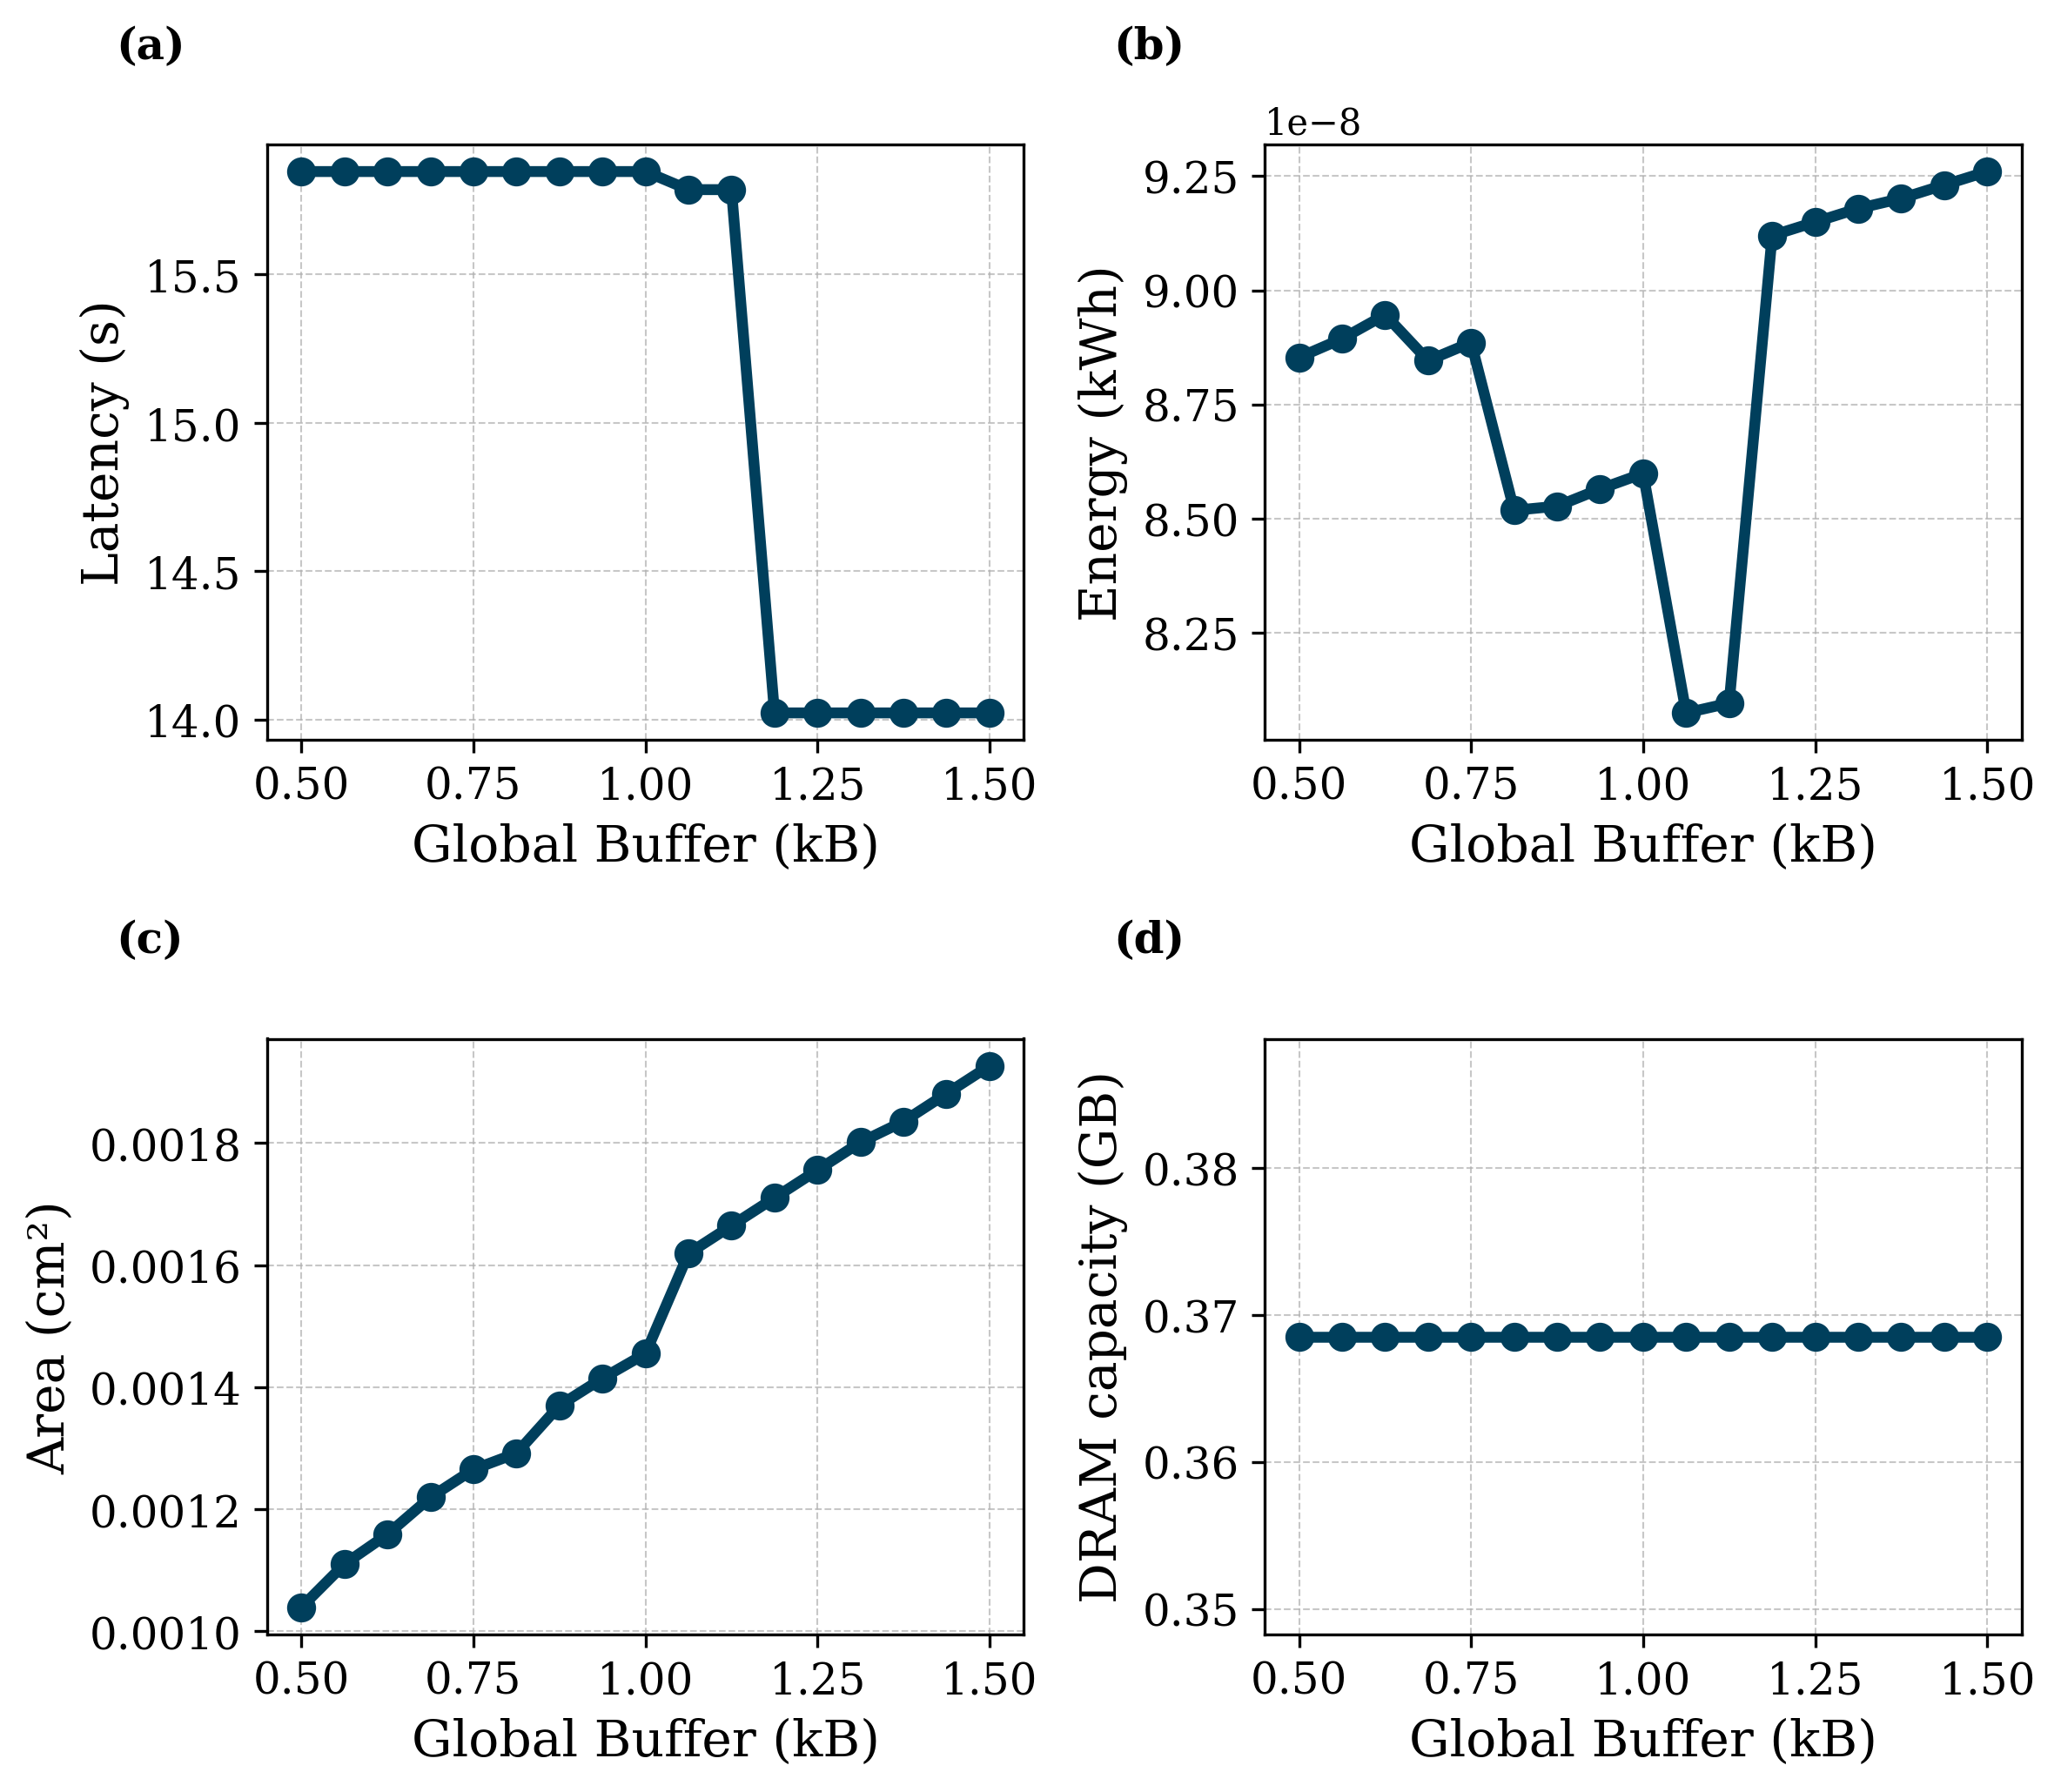

In [8]:
def plot_subplot(ax, y, ylabel):
    ax.plot(x, y, marker='o', markersize=7, linewidth=3, color=line_color)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

fig, axs = plt.subplots(2, 2, figsize=(8, 7), dpi=300)
data = [
    (total_latency_list, "Latency (s)"),
    (total_energy_kWh_list, "Energy (kWh)"),
    (total_area_cm2_list, "Area (cm²)"),
    (total_cap_GB_list, "DRAM capacity (GB)"),
]
subplot_labels = ['(a)', '(b)', '(c)', '(d)']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for idx, (pos, (y, ylabel)) in enumerate(zip(positions, data)):
    ax = axs[pos[0], pos[1]]
    plot_subplot(ax, y, ylabel)
    ax.text(-0.2, 1.2, subplot_labels[idx], transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')

# fig.suptitle("Hardware Specification", fontweight='bold',fontsize=16)
plt.tight_layout()
plt.savefig(f"figures/fig_{mode}_hardware_spec.pdf", format='pdf')
plt.savefig(f"figures/fig_{mode}_hardware_spec.svg", format='svg')
plt.show()
plt.close()

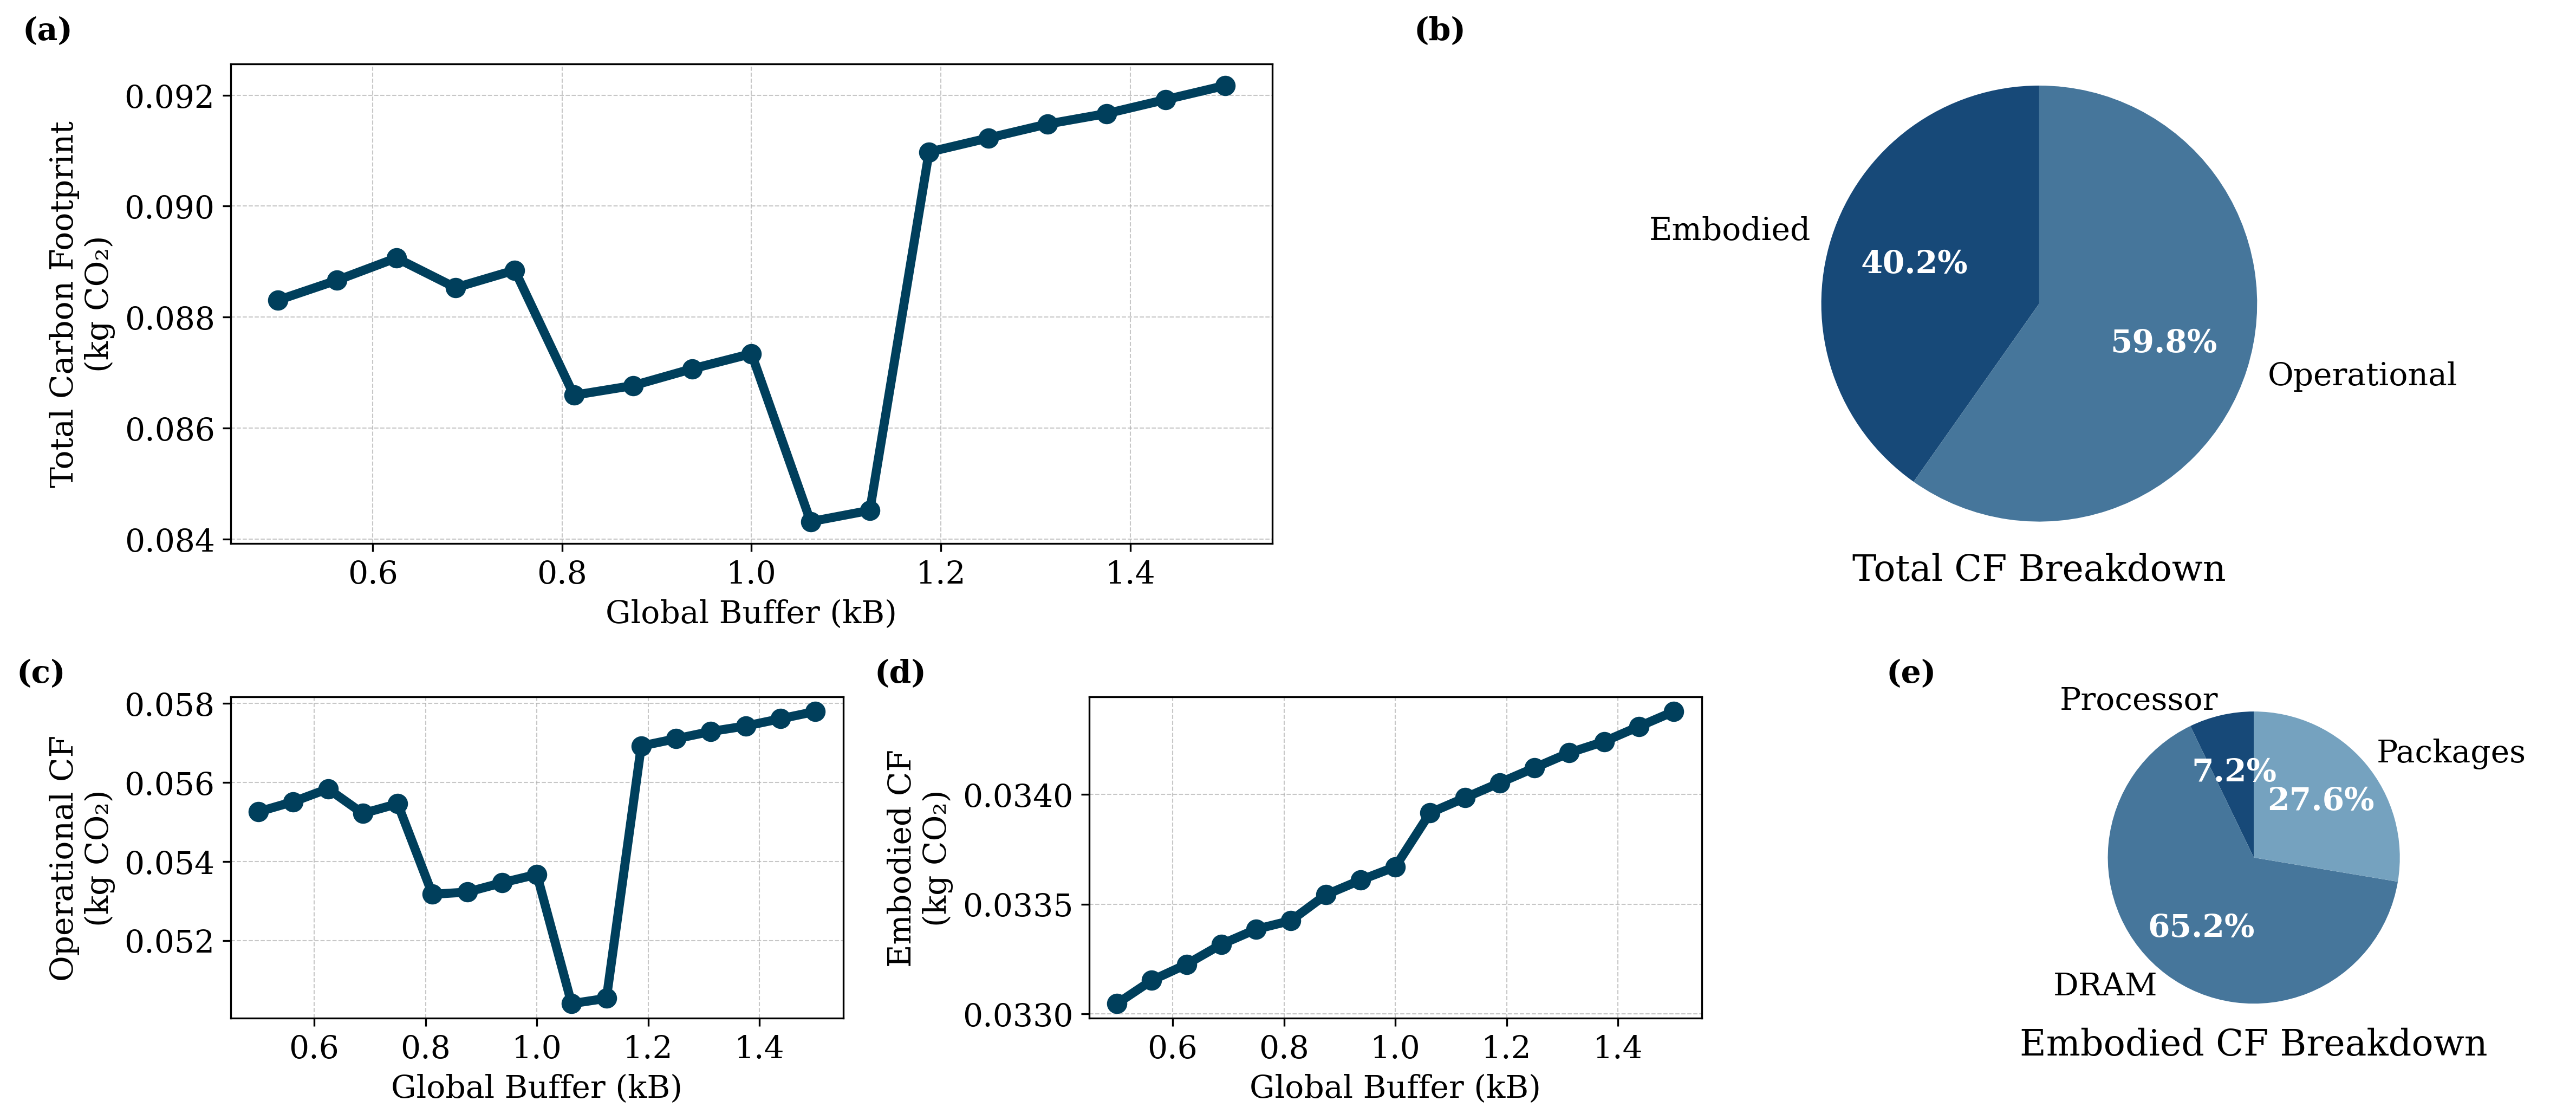

In [9]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16,7), dpi=300)
gs = GridSpec(7, 6, figure=fig)

ax1 = fig.add_subplot(gs[0:4, 0:3])
ax2 = fig.add_subplot(gs[0:4, 3:6])

ax3 = fig.add_subplot(gs[4:7, 0:2])
ax4 = fig.add_subplot(gs[4:7, 2:4])
ax5 = fig.add_subplot(gs[4:7, 4:6])

def plot_line(ax, y, ylabel):
    ax.plot(x, y, marker='o', markersize=8, linewidth=4, color=line_color)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Plotting function for pie charts
def plot_pie_ax(ax, sizes, labels, title=None):
    colors = ['#174978', '#46769B', '#75A2BF']
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        textprops={'fontsize': 14}
    )
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax.set_xlabel(title, fontsize=16)
    ax.axis('equal')

plot_line(ax3, cf_operational_list, "Operational CF\n(kg CO₂)")
plot_line(ax4, cf_embodied_list, "Embodied CF\n(kg CO₂)")
plot_line(ax1, cf_final_list, "Total Carbon Footprint\n(kg CO₂)")
plot_pie_ax(ax2, [cf_embodied_list[min_total_cf_index], cf_operational_list[min_total_cf_index]],
            ['Embodied', 'Operational'], "Total CF Breakdown\n")
plot_pie_ax(ax5, [cf_processor_list[min_total_cf_index], cf_DRAM_list[min_total_cf_index], cf_package_list[min_total_cf_index]],
            ['Processor', 'DRAM', 'Packages'], "Embodied CF Breakdown\n")

ax1.text(-0.2, 1.1, "(a)", transform=ax1.transAxes, fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='left')
ax2.text(-0.1, 1.1, "(b)", transform=ax2.transAxes, fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='left')
ax3.text(-0.35, 1.12, "(c)", transform=ax3.transAxes, fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='left')
ax4.text(-0.35, 1.12, "(d)", transform=ax4.transAxes, fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='left')
ax5.text(-0.1, 1.12, "(e)", transform=ax5.transAxes, fontsize=14, fontweight='bold', verticalalignment='top', horizontalalignment='left')

# fig.suptitle("Carbon Footprint", fontweight='bold',fontsize=18)
plt.tight_layout()
plt.savefig(f"figures/fig_{mode}_carbon_footprint.pdf", format='pdf')
plt.savefig(f"figures/fig_{mode}_carbon_footprint.svg", format='svg')
plt.show()
plt.close()

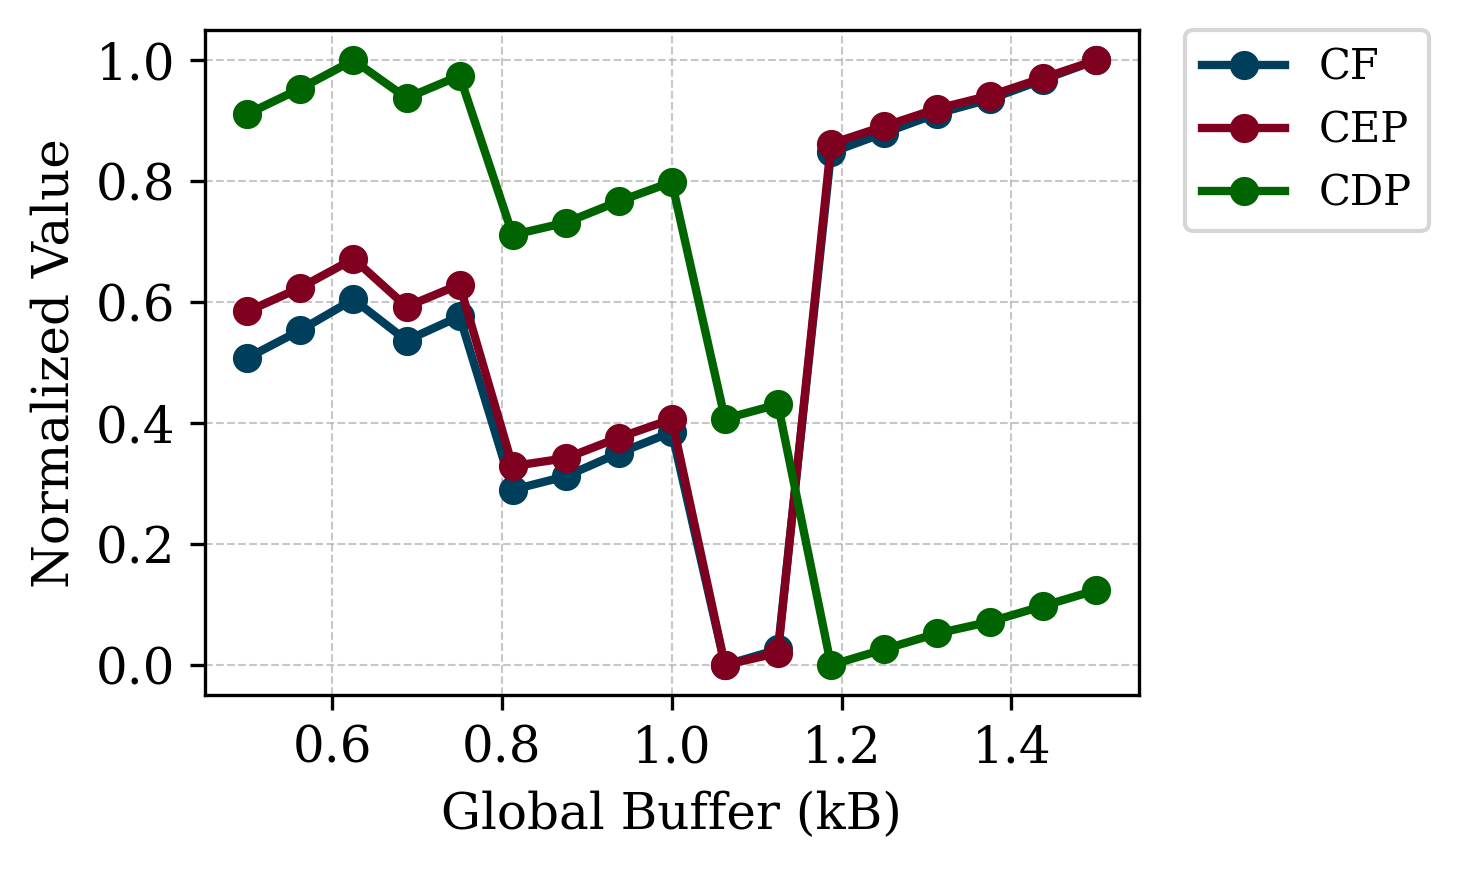

1.0625
1.0625
1.1875


In [10]:

def normalize(y):
    return (y - np.min(y)) / (np.max(y) - np.min(y))

def plot_normalized_lines(ys, labels, ylabel='Normalized Value'):
    plt.figure(figsize=(5, 3), dpi=300)
    colors = ['#003f5c','#800020','#006400']

    for y, label, color in zip(ys, labels, colors):
        y_norm = normalize(np.array(y))
        plt.plot(x, y_norm, marker='o', label=label, linewidth=2, color=color)

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(f"figures/fig_{mode}_optimization_metircs.pdf", format='pdf')
    plt.savefig(f"figures/fig_{mode}_optimization_metircs.svg", format='svg')
    plt.show()
    plt.close()


plot_normalized_lines([cf_final_np, CEP_np, CDP_np], ['CF','CEP','CDP'])
print(x[cf_final_list.index(min(cf_final_list))])
print(x[CEP_list.index(min(CEP_list))])
print(x[CDP_list.index(min(CDP_list))])
